In [245]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import requests
from matplotlib import pyplot as plt
import warnings 
warnings.filterwarnings('ignore')


In [5]:
def load_data(file_path, url_path):
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
    else:
        d,i,offset_size = [],0,100000
        k = offset_size
        while k == offset_size:
            if i > 10:
                break
            r=requests.get(
                url = url_path, 
                params={
                    '$limit':offset_size, 
                    '$offset':offset_size*i
                }
            )
    
            as_df = pd.DataFrame(r.json())
            k = len(as_df)
            i += 1
            d.append(as_df)
    
        df = pd.concat(d)
        df.to_csv(file_path)
        df.head(10)
    return df

In [179]:
def spatial_inner_join(dataframe_a, dataframe_b):
    # Convert dataframe_a (type 1 crimes DataFrame) into a GeoDataFrame with points
    geometry_a = [Point(xy) for xy in zip(dataframe_a['Longitude'], dataframe_a['Latitude'])]
    gdf_a = gpd.GeoDataFrame(dataframe_a, geometry=gpd.GeoSeries(geometry_a), crs="EPSG:4326")
    
    # Check if dataframe_b (Zips) has a CRS set, and handle appropriately
    if dataframe_b.crs is None:
        # If dataframe_b doesn't have a CRS, set it to WGS 84 (EPSG:4326)
        gdf_b = gpd.GeoDataFrame(dataframe_b, geometry=dataframe_b['geometry']).set_crs("EPSG:4326", allow_override=True)
    else:
        # If dataframe_b has a CRS that differs from EPSG:4326, reproject dataframe_a to match
        gdf_b = gpd.GeoDataFrame(dataframe_b, geometry=dataframe_b['geometry'])
        if gdf_b.crs != gdf_a.crs:
            gdf_a = gdf_a.to_crs(gdf_b.crs)  # Reproject dataframe_a to match dataframe_b's CRS

    # Perform a spatial join where points are within the geometries
    joined = gpd.sjoin(gdf_a, gdf_b, how="inner", op="within")

    return joined

In [7]:
tree_census_df =load_data('data/tree_census_15.csv', 'https://data.cityofnewyork.us/resource/5rq2-4hqu.json')

In [9]:
air_quality_df = load_data('data/Air_Quality_20241206.csv', 'https://data.cityofnewyork.us/resource/c3uy-2p5r.json')

In [11]:
green_streets_df = load_data('data/Greenstreets.csv', 'https://data.cityofnewyork.us/resource/mk9u-qu7i.json')

In [13]:
property_valuation_df = load_data('data/Property_Valuation_and_Assessment_Data_20241125.csv', 'https://data.cityofnewyork.us/resource/yjxr-fw8i.json')

# Tree Census Data Sanitation 

In [15]:
tree_census_df.shape

(683788, 43)

# Air Quality Data Sanitation

In [17]:
air_quality_df.head()

,Unnamed: 0,unique_id,indicator_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,time_period,start_date,data_value
0,0,827080,386,Ozone (O3),Mean,ppb,UHF34,104.0,Pelham - Throgs Neck,Summer 2022,2022-06-01T00:00:00.000,33.3
1,1,827061,386,Ozone (O3),Mean,ppb,UHF34,405.0,Ridgewood - Forest Hills,Summer 2022,2022-06-01T00:00:00.000,34.2
2,2,827067,386,Ozone (O3),Mean,ppb,UHF34,302.0,Central Harlem - Morningside Heights,Summer 2022,2022-06-01T00:00:00.000,30.9
3,3,827081,386,Ozone (O3),Mean,ppb,UHF34,103.0,Fordham - Bronx Pk,Summer 2022,2022-06-01T00:00:00.000,31.7
4,4,825967,375,Nitrogen dioxide (NO2),Mean,ppb,UHF34,104.0,Pelham - Throgs Neck,Summer 2022,2022-06-01T00:00:00.000,12.0


In [19]:
air_quality_df = air_quality_df.dropna(subset=['geo_join_id'])

In [21]:
air_quality_df['geo_join_id'] = air_quality_df['geo_join_id'].astype('int64')

In [27]:
air_quality_df['name'].unique()

array(['Ozone (O3)', 'Nitrogen dioxide (NO2)', 'Fine particles (PM 2.5)',
       'Annual vehicle miles traveled (cars)',
       'Annual vehicle miles traveled (trucks)',
       'Annual vehicle miles traveled',
       'Respiratory hospitalizations due to PM2.5 (age 20+)',
       'Asthma emergency department visits due to PM2.5',
       'Asthma emergency departments visits due to Ozone',
       'Cardiovascular hospitalizations due to PM2.5 (age 40+)',
       'Cardiac and respiratory deaths due to Ozone',
       'Asthma hospitalizations due to Ozone', 'Deaths due to PM2.5',
       'Boiler Emissions- Total PM2.5 Emissions',
       'Boiler Emissions- Total SO2 Emissions',
       'Boiler Emissions- Total NOx Emissions',
       'Outdoor Air Toxics - Formaldehyde',
       'Outdoor Air Toxics - Benzene'], dtype=object)

In [91]:
air_quality_df = air_quality_df[air_quality_df['name'].str.contains('Outdoor Air Toxics') | air_quality_df['name'].str.contains('Boiler Emissions') ]

In [221]:
simplified_tree_df = tree_census_df[['zipcode', 'cb_num']]

In [223]:
simplified_tree_df = simplified_tree_df[(simplified_tree_df['zipcode'] >= 10000) & (simplified_tree_df['zipcode']<11500)]

In [225]:
simplified_tree_df.shape

(670351, 2)

In [227]:
simplified_tree_df = simplified_tree_df.drop_duplicates(subset=['cb_num'])

In [229]:
simplified_tree_df.shape

(59, 2)

In [247]:
zips = gpd.read_file('ZIPCODE/ZIP_CODE_040114.shp')
zips.head(10)

#get population, area info per zip, to build per-capita feats wrto the tree data 
zips_tr = zips[[
    'ZIPCODE','POPULATION','AREA','geometry'
]]
zips_tr['ZIPCODE'] = zips_tr['ZIPCODE'].astype(np.int64)

In [269]:
air_quality_geo_df =  air_quality_df.merge(simplified_tree_df, left_on='geo_join_id', right_on='cb_num')

In [271]:
air_quality_geo_df.head()

,Unnamed: 0,unique_id,indicator_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,time_period,start_date,data_value,zipcode,cb_num
0,8151,179825,641,Boiler Emissions- Total PM2.5 Emissions,Number per km2,number,UHF42,406,Fresh Meadows,2015,2015-01-01T00:00:00.000,0.4,11375,406
1,8157,179783,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,104,Pelham - Throgs Neck,2015,2015-01-01T00:00:00.000,2.8,10019,104
2,8158,179773,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,404,Bayside - Little Neck,2015,2015-01-01T00:00:00.000,0.9,11373,404
3,8159,179722,642,Boiler Emissions- Total NOx Emissions,Number per km2,number,UHF42,410,Rockaways,2015,2015-01-01T00:00:00.000,6.1,11414,410
4,8160,179792,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,206,Borough Park,2015,2015-01-01T00:00:00.000,1.1,10457,206


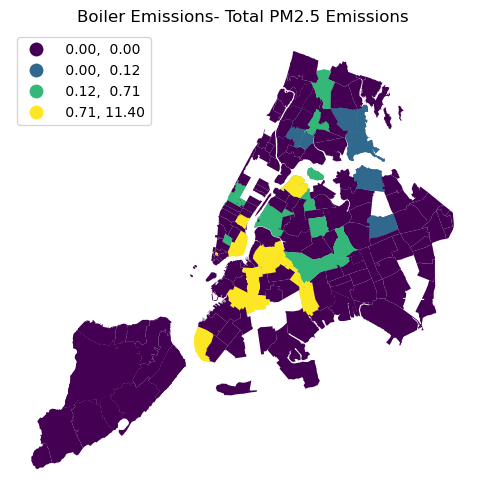

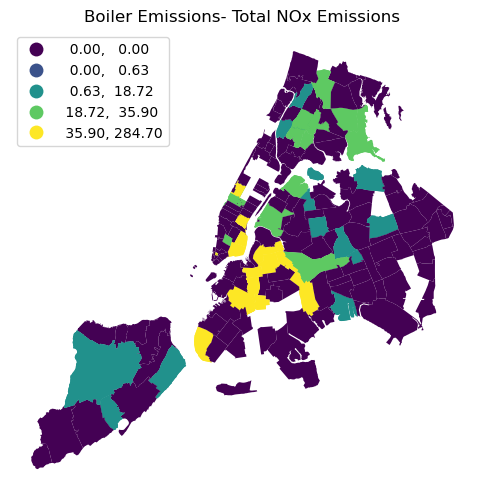

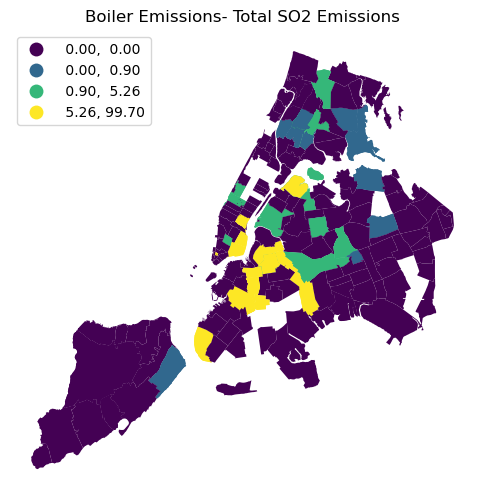

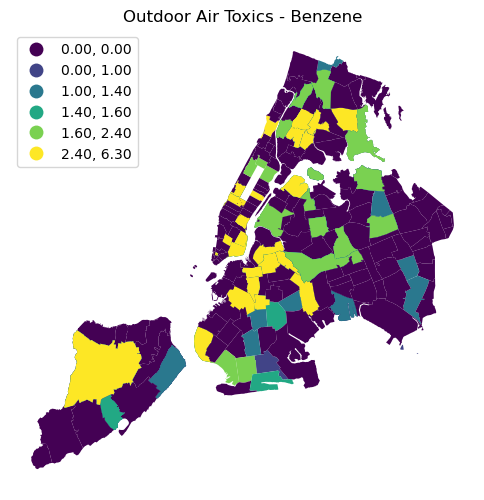

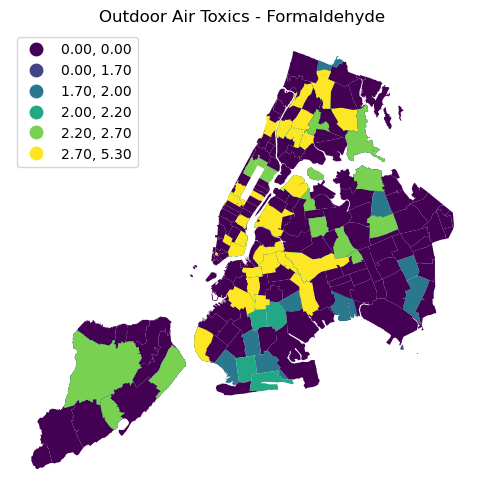

In [459]:
air_quality_geo_merged_df = air_quality_geo_df.merge(
    zips_tr, 
    how='outer', 
    left_on='zipcode', 
    right_on='ZIPCODE', 
)
air_quality_geo_merged_df = air_quality_geo_merged_df[(air_quality_geo_merged_df['ZIPCODE'] >= 10000) & (air_quality_geo_merged_df['ZIPCODE']<11500)]
air_quality_geo_merged_df = air_quality_geo_merged_df[['ZIPCODE', 'name', 'data_value', 'geometry']]
air_quality_geo_merged_df['data_value'] = air_quality_geo_merged_df['data_value'].fillna(0)
air_quality_geo_merged_df['name'] = air_quality_geo_merged_df['name'].fillna('')
air_quality_geo_merged_df.head()

measure_types = air_quality_geo_merged_df['name'].unique()

for idx, type in enumerate(measure_types):
    if type != '':
        air_quality_geo_trunc = gpd.GeoDataFrame(air_quality_geo_merged_df[(air_quality_geo_merged_df['name'] == type) | (air_quality_geo_merged_df['name'] == '')])
        air_quality_geo_trunc.plot(
            figsize=(6,6), 
            column='data_value', 
            markersize=0.01,
            k=10, 
            scheme='Quantiles', 
            legend=True, 
            legend_kwds={'loc': 'upper left'}
        )
        plt.title(type)
        plt.axis('off')
        plt.show()

# Green Streets Data Sanitation

In [25]:
green_streets_df.shape

(2753, 26)

In [203]:
green_streets_df.rename(columns={
    'Unnamed: 0': 'Number','acres': 'ACRES','borough': 'BOROUGH','commissiondate': 'COMMISSIONDATE',
    'communityboard': 'COMMUNITYBOARD','councildistrict': 'COUNCILDISTRICT','department': 'DEPARTMENT',
    'description': 'DESCRIPTION','featurestatus': 'FEATURESTATUS','gispropnum': 'GISPROPNUM','gsgroup': 'GSGROUP',
    'gispropnum': 'GISPROPNUM','location': 'LOCATION','mou': 'MOU','nys_assembly': 'NYS_ASSEMBLY',
    'nys_senate': 'NYS_SENATE','omppropid': 'OMPPROPID','parentid': 'PARENTID','precinct': 'PRECINCT','sitename': 'SITENAME',
    'starea': 'STArea','stlength': 'STLength','system': 'SYSTEM','us_congress': 'US_CONGRESS','zipcode': 'ZIPCODE',
    'multipolygon': 'multipolygon','gstype': 'GSTYPE','subcategory': 'SUBCATEGORY'
}, inplace=True)

print(green_streets_df.columns)

Index(['Number', 'ACRES', 'BOROUGH', 'COMMISSIONDATE', 'COMMUNITYBOARD',
       'COUNCILDISTRICT', 'DEPARTMENT', 'DESCRIPTION', 'FEATURESTATUS',
       'GISPROPNUM', 'GSGROUP', 'LOCATION', 'MOU', 'NYS_ASSEMBLY',
       'NYS_SENATE', 'OMPPROPID', 'PARENTID', 'PRECINCT', 'SITENAME', 'STArea',
       'STLength', 'SYSTEM', 'US_CONGRESS', 'ZIPCODE', 'multipolygon',
       'GSTYPE', 'SUBCATEGORY'],
      dtype='object')


In [205]:
#Check for Greenstreets
print(green_streets_df['DESCRIPTION'].isna().sum())
print((green_streets_df['DESCRIPTION'] == "").sum())

0
0


In [207]:
#Check for all invalid values in both acres and zipcode columns
df_invalid = green_streets_df[
    green_streets_df['ACRES'].isna() | (green_streets_df['ACRES'] <= 0) | ~green_streets_df['ACRES'].apply(lambda x: isinstance(x, (int, float)) and not pd.isna(x)) | (green_streets_df['ACRES'] == '') |
    green_streets_df['ZIPCODE'].isna() | (green_streets_df['ZIPCODE'] == 0) | ~green_streets_df['ZIPCODE'].apply(lambda x: str(x).isdigit()) | (green_streets_df['ZIPCODE'] == '')
]

print("Rows with invalid Acres or ZIPCODE values:")
print(df_invalid[['ACRES', 'ZIPCODE']])

print(f"\nNumber of rows with invalid Acres or ZIPCODE: {df_invalid.shape[0]}")

Rows with invalid Acres or ZIPCODE values:
         ACRES              ZIPCODE
632   0.034391         11377, 11378
809   0.008332         11432, 11433
961   0.119891         11374, 11375
1072  0.069322         11213, 11233
1148  0.086223         11207, 11208
1379  0.034699         10463, 10471
1800  0.119379         11423, 11427
1823  0.019118         11370, 11371
1841  0.020756         11370, 11371
1842  0.020843         11370, 11371
1855  0.020318         11370, 11371
1856  0.022438         11370, 11371
1899  0.029911                  NaN
1900  0.044952                  NaN
1901  0.036727                  NaN
1902  0.039310                  NaN
1927  0.043888                 Null
1930  0.237340                 Null
1958  0.019172         11370, 11371
1968  1.203357         10025, 10027
1986  0.018848         11370, 11371
1987  0.019955         11370, 11371
2004  0.841732         10026, 10027
2091  0.409322  10003, 10010, 10016
2093  0.744071         11372, 11377
2098  0.125355       

In [209]:
#Drop all invalid values in both columns
df_cleaned = green_streets_df[
    ~(green_streets_df['ACRES'].isna() | (green_streets_df['ACRES'] <= 0) | ~green_streets_df['ACRES'].apply(lambda x: isinstance(x, (int, float)) and not pd.isna(x)) | (green_streets_df['ACRES'] == '') |
    green_streets_df['ZIPCODE'].isna() | (green_streets_df['ZIPCODE'] == 0) | ~green_streets_df['ZIPCODE'].apply(lambda x: str(x).isdigit()) | (green_streets_df['ZIPCODE'] == '')
    )]
df_cleaned.shape

(2722, 27)

In [211]:
#Check for invalid values 
df_check = df_cleaned[
    df_cleaned['ACRES'].isna() | (df_cleaned['ACRES'] <= 0) | ~df_cleaned['ACRES'].apply(lambda x: isinstance(x, (int, float)) and not pd.isna(x)) | (df_cleaned['ACRES'] == '') |
    df_cleaned['ZIPCODE'].isna() | (df_cleaned['ZIPCODE'] == 0) | ~df_cleaned['ZIPCODE'].apply(lambda x: str(x).isdigit()) | (df_cleaned['ZIPCODE'] == '')
]
print(df_check[['ACRES', 'ZIPCODE']])

Empty DataFrame
Columns: [ACRES, ZIPCODE]
Index: []


In [213]:
#NYC zipcodes range from 10001 to 11697 in five boroughs.
nyc_zipcodes = [str(i) for i in range(10001, 11697)]
Greenstreets_filtered = df_cleaned[df_cleaned['ZIPCODE'].isin(nyc_zipcodes)]

Greenstreets_filtered.shape

(2716, 27)

In [215]:
Greenstreets_filtered.to_csv('Filtered_Greenstreets.csv', index=False)

In [217]:
Greenstreets_filtered = Greenstreets_filtered.rename(columns={'ZIPCODE': 'zipcode'})
Greenstreets_filtered.head(1)

,Number,ACRES,BOROUGH,COMMISSIONDATE,COMMUNITYBOARD,COUNCILDISTRICT,DEPARTMENT,DESCRIPTION,FEATURESTATUS,GISPROPNUM,...,PRECINCT,SITENAME,STArea,STLength,SYSTEM,US_CONGRESS,zipcode,multipolygon,GSTYPE,SUBCATEGORY
0,0,0.070279,Q,2003-12-01T00:00:00.000,414.0,32.0,Q-14,Greenstreet,Active,QZ756,...,100,Greenstreet,3061.338028,411.528121,QZ756,5,11694,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",NaN,NaN


In [237]:
air_quality_geo_df['zipcode'] = air_quality_geo_df['zipcode'].astype(str)
Greenstreets_filtered['zipcode'] = Greenstreets_filtered['zipcode'].astype(str)

air_quality_geo_df = air_quality_geo_df.merge(Greenstreets_filtered, on='zipcode', how='inner')

In [239]:
#Here is the greenstreet data merged with air quailty and tree census
#Here is the greenstreet data merged with air quailty and tree census
#Here is the greenstreet data merged with air quailty and tree census
#Here is the greenstreet data merged with air quailty and tree census
#Here is the greenstreet data merged with air quailty and tree census
#Here is the greenstreet data merged with air quailty and tree census
air_quality_geo_df.columns

Index(['Unnamed: 0', 'unique_id', 'indicator_id', 'name', 'measure',
       'measure_info', 'geo_type_name', 'geo_join_id', 'geo_place_name',
       'time_period', 'start_date', 'data_value', 'zipcode', 'cb_num',
       'Number', 'ACRES', 'BOROUGH', 'COMMISSIONDATE', 'COMMUNITYBOARD',
       'COUNCILDISTRICT', 'DEPARTMENT', 'DESCRIPTION', 'FEATURESTATUS',
       'GISPROPNUM', 'GSGROUP', 'LOCATION', 'MOU', 'NYS_ASSEMBLY',
       'NYS_SENATE', 'OMPPROPID', 'PARENTID', 'PRECINCT', 'SITENAME', 'STArea',
       'STLength', 'SYSTEM', 'US_CONGRESS', 'multipolygon', 'GSTYPE',
       'SUBCATEGORY'],
      dtype='object')

# Property Valuation Data Sanitation

In [26]:
property_valuation_df.shape

(1100000, 45)